In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math

from pytransit import QuadraticModel
from ldtk import LDPSetCreator, BoxcarFilter
import emcee
import corner
from multiprocessing import Pool

import os
os.environ['OMP_NUM_THREADS']='1'
os.nice(19)

19

# Loading light curve data

In [6]:
data_file = 'TOI-519b_220123_muscat3_z_c12131415_r12.csv'
bjd, flux, flux_err = np.loadtxt(data_file, delimiter=',', skiprows=1,\
                                 usecols=(0,1,2), unpack=True)

# Plotting light curve

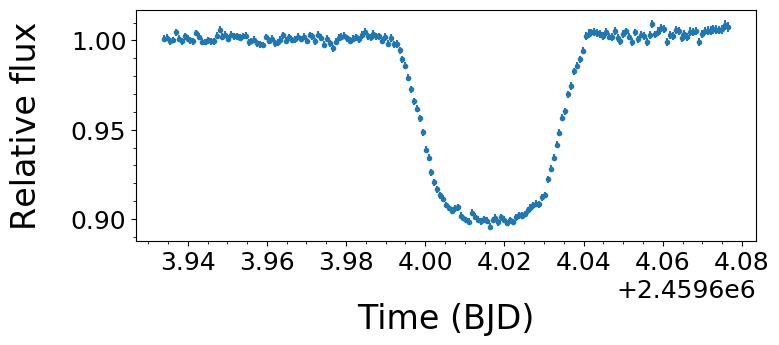

In [7]:
plt.figure(figsize=(8,3))
plt.rcParams['font.size']=18
plt.errorbar(bjd, flux, yerr=flux_err, fmt='.')
plt.xlabel('Time (BJD)', fontsize=24, labelpad=20)
plt.ylabel('Relative flux', fontsize=24, labelpad=20)
plt.minorticks_on()

# Initializing PyTransit model

In [9]:
ttr = QuadraticModel()
ttr.set_data(bjd)

# Extracting theoretical values of limb-darkening coefficients using LDTK 

In [16]:
%%time

## Filter setting for MuSCAT
filters = [
            # BoxcarFilter('g', 400, 550),
            # BoxcarFilter('r', 550, 700),
            # BoxcarFilter('i', 700, 820),
            BoxcarFilter('z_s', 820, 920),
          ]

## Stellar parameters
sc = LDPSetCreator(teff=(3322,   49), # effective temperature
                   logg=(4.87,  0.03), # surface gravity
                      z=(0.27, 0.09), # metallicity
                     filters=filters)


ps = sc.create_profiles()                # Create the limb darkening profiles
qc,qe = ps.coeffs_qd(do_mc=True, n_mc_samples=10000)         # Estimate quadratic law coefficients

    
print(qc)
print(qe)

[[0.25077427 0.33753155]]
[[0.00491006 0.00821089]]
CPU times: user 832 ms, sys: 258 ms, total: 1.09 s
Wall time: 2.15 s


# Log probability functions

In [17]:
def log_likelihood(p):
    
    b, k, ln_aRs, Tc, u1, u2 = p[0:6]
    
    aRs = np.exp(ln_aRs) # a/Rs
    inc = math.acos(b/aRs)
    ldc = np.array((u1, u2))
       
    if b < 0 or b+k >= 1:
        return -np.inf
    
    if aRs <= 0:
        return -np.inf
    
    if b/aRs >= 1:
        return -np.inf

    if k <= 0:
        return -np.inf
        
    if u1 <= 0 or u2 <= 0 or u1+u2 >= 1:
            return -np.inf
        
        
    model_flux_tr = ttr.evaluate_ps(k, ldc, Tc, P, aRs, inc, 0, 0)
    
    c = np.polyfit(bjd-Tc, flux/model_flux_tr, 2) # least square fit with 2nd order polynomial
    model_flux = model_flux_tr * np.polyval(c, bjd-Tc)
    
    ll = -0.5*np.sum( (flux - model_flux)**2 / flux_err**2 )\
                -0.5*np.sum( np.log(2*np.pi*flux_err**2) )
     
    return ll

In [30]:
def log_prior(p):
              
    b, k, ln_aRs, Tc, u1, u2 = p[0:6]
    
    lp = 0
    
    ## limb-darkening coeff.
    err_scale_factor = 10
    lp += -0.5 * (u1 - qc[0][0])**2 / (qe[0][0]*err_scale_factor)**2
    lp += -0.5 * (u2 - qc[0][1])**2 / (qe[0][1]*err_scale_factor)**2

    return lp

In [19]:
def log_probability(p):
    
    lpri = log_prior(p)
    ll = log_likelihood(p)
    
    return lpri + ll

In [20]:
def neg_log_probability(p):
    
    return -log_probability(p)

# Setting initial values of the parameters

In [21]:
P = 1.2652328 # days, global parameter

b0 = 0.1
k0 = 0.3
ln_aRs0 = np.log(10)
Tc0 = 2459604.02
u10, u20 = qc[0][0], qc[0][1]

p0 = [b0, k0, ln_aRs0, Tc0, u10, u20]
npar = len(p0)
print('number of parameters = ', npar)

lpro = log_probability(p0)
print('initial log probability = ', lpro)

number of parameters =  6
initial log probability =  -1827.9822282546936


# Minimizing negative log probability

In [22]:
res = minimize(neg_log_probability, p0, method='Nelder-Mead')

print('minimum function value = ', res.fun)
print('success for minimization: ', res.success)
print('best-fit parameter values: ', res.x)

minimum function value =  -908.8690949104722
success for minimization:  True
best-fit parameter values:  [1.03828142e-01 2.99999964e-01 2.32956823e+00 2.45960402e+06
 2.50774274e-01 3.37531535e-01]


# MCMC calculation

In [23]:
%%time

ndim, nwalkers = npar, 30
nsteps = 10000
pos = [res.x + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]

filename = 'mcmc_trfit.hd5' # output file for sampled parameters
!rm -f $filename
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


with Pool(4) as pool: # number of CPU cores (threads) for parallel computation 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,\
                        backend=backend, pool=pool, )
    sampler.run_mcmc(pos, nsteps, progress=True)

100%|█████████████████████████████████████████████████████████████████| 10000/10000 [01:14<00:00, 133.98it/s]

CPU times: user 50.2 s, sys: 6.9 s, total: 57.1 s
Wall time: 1min 14s


10000


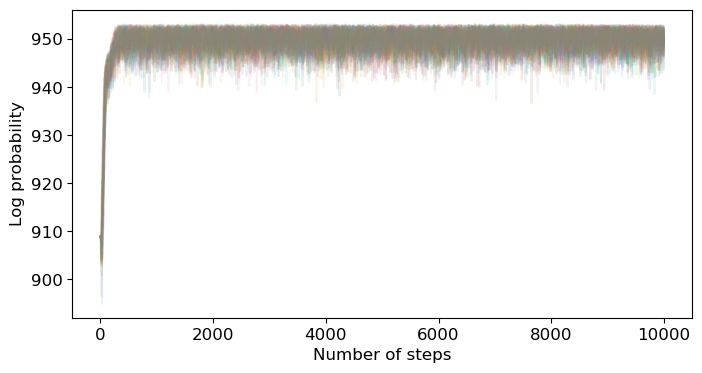

In [25]:
log_prob = sampler.get_log_prob()

plt.figure(figsize=(8,4))
plt.rcParams['font.size']=12

for i in range(nwalkers):
    plt.plot(log_prob[:,i],alpha=0.1)
    
plt.xlabel('Number of steps', fontsize=20)
plt.ylabel('Log probability', fontsize=20)
plt.show()



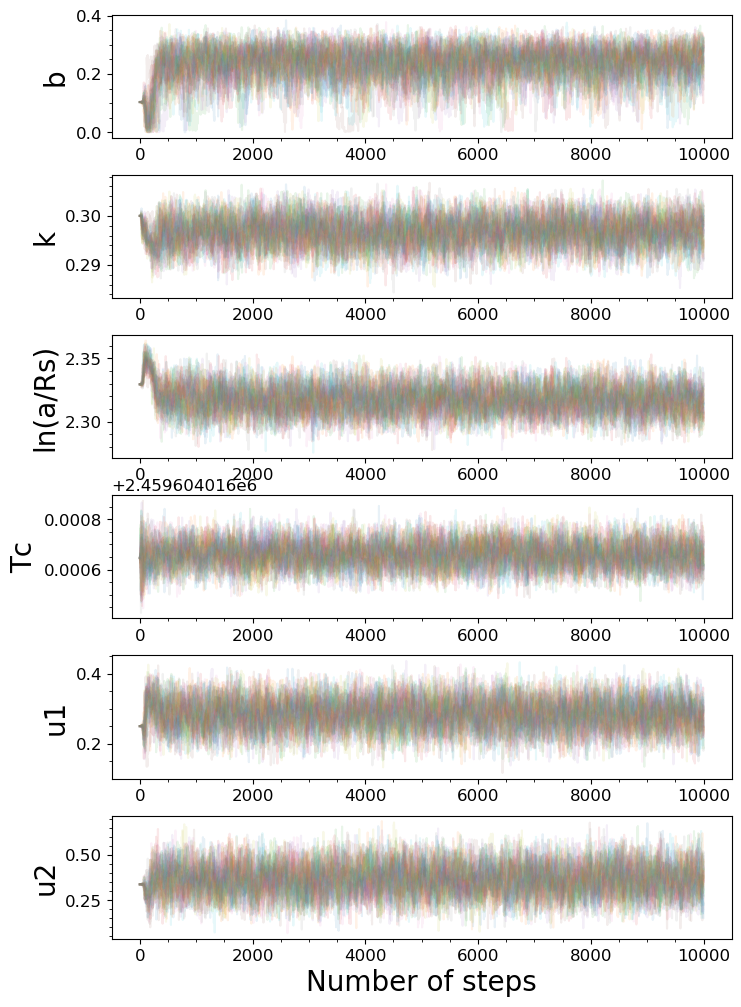

In [26]:
samples = sampler.get_chain()

labels=['b', 'k', 'ln(a/Rs)', 'Tc', 'u1', 'u2']

fig, ax = plt.subplots(npar, 1, figsize=(8,2*npar))
plt.subplots_adjust(hspace=0.3)
plt.rcParams['font.size']=12

for i in range(npar):
    for j in range(nwalkers):
        ax[i].plot(samples[:,j,i],alpha=0.1)
        ax[i].set_ylabel(labels[i], fontsize=20)
        ax[i].minorticks_on()
    
ax[-1].set_xlabel('Number of steps', fontsize=20)

plt.show()

# Showing corner plot

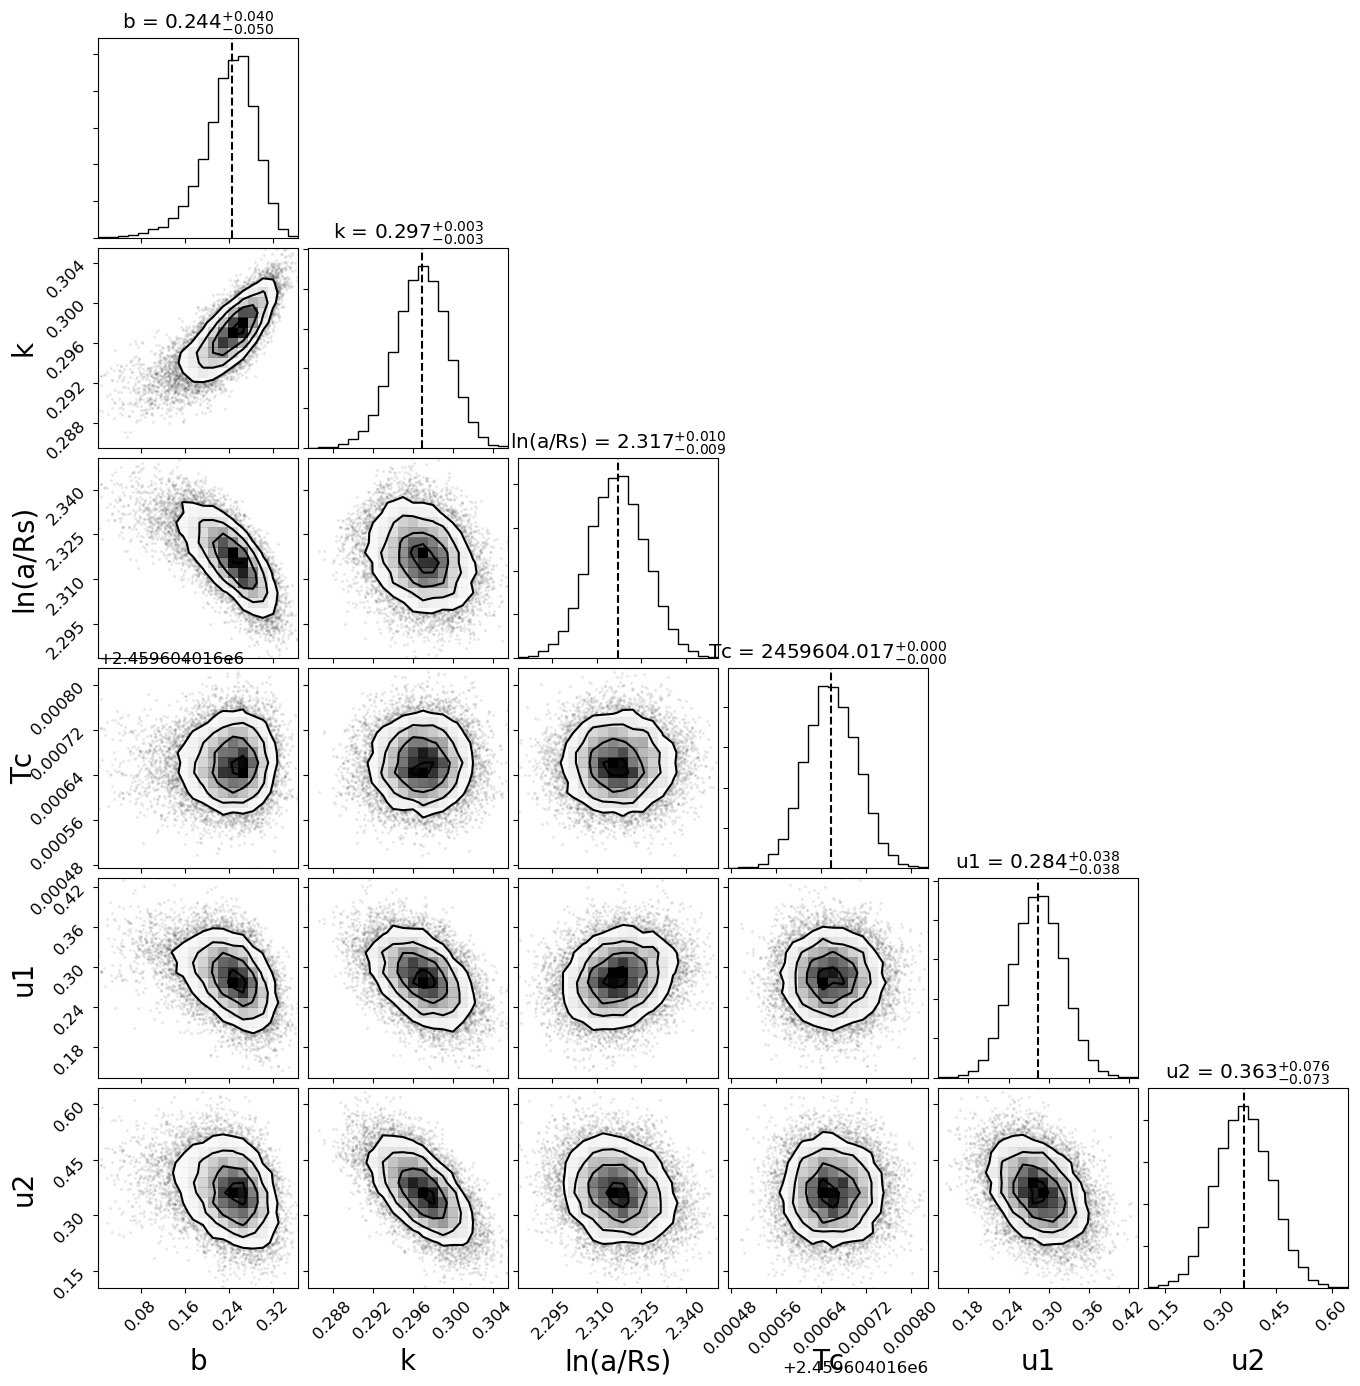

In [27]:
discard=5000
thin=10
log_prob = sampler.get_log_prob(flat=True, discard=discard, thin=thin)
samples = sampler.get_chain(flat=True, discard=discard, thin=thin)

plt.rcParams['font.size']=12
fig = corner.corner(samples, labels=labels, quantiles=[0.5,],\
                   show_titles=True, title_fmt='.3f', label_kwargs={'fontsize':20})


# Median values and 1 sigma confidence intervals

In [28]:
for i in range(npar):
    
    hi = np.percentile(samples[:,i], 84.15)
    lo = np.percentile(samples[:,i], 15.85)
    med = np.median(samples[:,i])
    
    if i==3:
        print('{0} = {1:.6f} +{2:.6f} -{3:.6f}'.format(labels[i], med, hi-med, med-lo))
    else:
        print('{0} = {1:.3f} +{2:.3f} -{3:.3f}'.format(labels[i], med, hi-med, med-lo))

b = 0.244 +0.040 -0.051
k = 0.297 +0.003 -0.003
ln(a/Rs) = 2.317 +0.010 -0.009
Tc = 2459604.016658 +0.000047 -0.000045
u1 = 0.284 +0.038 -0.038
u2 = 0.363 +0.076 -0.074


# Plotting light curve with the best-fit model

best-fit parameters:  [2.45539304e-01 2.96709779e-01 2.31619198e+00 2.45960402e+06
 2.79718940e-01 3.82919723e-01]


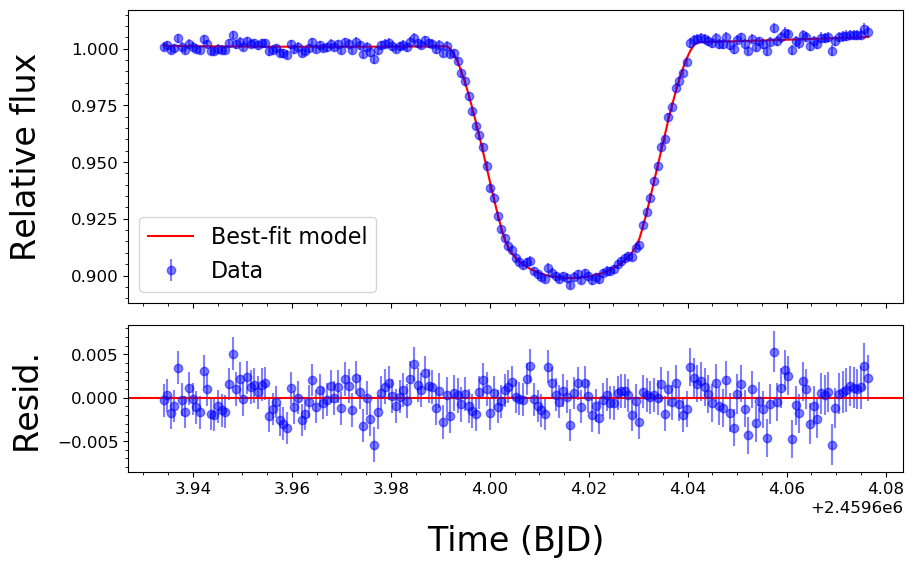

In [29]:
argmax = np.argmax(log_prob)
bestp = samples[argmax,:]
print('best-fit parameters: ', bestp)

b, k, ln_aRs, Tc, u1, u2 = bestp[0:6]

aRs = np.exp(ln_aRs) # a/Rs
inc = math.acos(b/aRs)
ldc = np.array((u1, u2))

model_flux_tr = ttr.evaluate_ps(k, ldc, Tc, P, aRs, inc, 0, 0)
c = np.polyfit(bjd-Tc, flux/model_flux_tr, 2) # least square fit with 2nd order polynomial
model_flux = model_flux_tr * np.polyval(c, bjd-Tc)
residual = flux - model_flux

fig, ax = plt.subplots(2,1, figsize=(10,6),\
                       sharex='col', gridspec_kw={'height_ratios':[2,1]})
plt.subplots_adjust(hspace=0.1)
plt.rcParams['font.size']=16

ax[0].errorbar(bjd, flux, yerr=flux_err, fmt='o', color='blue', alpha=0.5, label='Data')
ax[0].plot(bjd, model_flux, color='red', label='Best-fit model')
ax[0].set_ylabel('Relative flux', labelpad=20, fontsize=24)
ax[0].legend()

ax[1].errorbar(bjd, residual, yerr=flux_err, fmt='o', color='blue', alpha=0.5)
ax[1].axhline(0, color='red')
ax[1].set_xlabel('Time (BJD)', labelpad=20, fontsize=24)
ax[1].set_ylabel('Resid.', labelpad=10, fontsize=24)

for i in range(2):
    ax[i].minorticks_on()


plt.show()

